In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import keras
from keras import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
with open('Data\\Training\\test_1\\stats.pkl', 'rb') as f:
    stats = pickle.load(f)

In [3]:
stats

{'best_score_from_gen': [993447.9610048548,
  11631722.241671389,
  0.8379399301743448,
  229734.99847642425,
  5368490.803442722,
  5368490.803442722,
  0.9005659331981786,
  5832.422626471127,
  5368490.803442722,
  993447.9610048548,
  2.042008752912707,
  16.222118134110477,
  94113.76614899526,
  94113.76614899526,
  36919798.33768609,
  248.27071216988287,
  94113.77420661424,
  94113.77420661424,
  6.490510090361271,
  11.346733888443227,
  94113.77420661424,
  94113.77420661424,
  94113.77420661424,
  514.0918039782816,
  94113.77420661424],
 'best_score_total': [39,
  58,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59,
  59],
 'worst_score_from_gen': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0003743413151208328,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.14585271921364e-05,
  0.0,
  0.0,
  0.0,
  0.0],
 'avg_best_score_total': [19.5,
  35.7

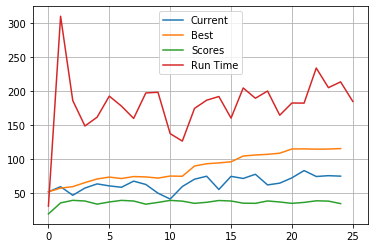

In [4]:
plt.plot(stats['avg_size_from_gen'], label='Current')
plt.plot(stats['avg_size_total'], label='Best')
plt.plot(stats['avg_best_score_total'], label='Scores')
plt.plot(stats['gen_run_time'], label='Run Time')
plt.grid()
plt.legend()
plt.show()

In [5]:
from os import listdir
from os.path import isfile, join
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

import json

def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

In [6]:
path = 'Data\\Stocks\\All\\'
tickers = [f.split(sep='.')[0] for f in listdir(path) if isfile(join(path, f))]

In [7]:
api_key = '930464ada60b2c5c45b327be13aef84b'

In [8]:
url = ("https://financialmodelingprep.com/api/v3/profile/BMRA?apikey="+api_key)
industry = (get_jsonparsed_data(url)[0]['sector'])
industry

KeyError: 0

In [ ]:
# Company Profile
complete_healthcare_list = []
for i, stock in enumerate(tickers):
    url = ("https://financialmodelingprep.com/api/v3/profile/"+stock+"?apikey="+api_key)
    try:
        sector = (get_jsonparsed_data(url)[0]['sector'])
        if sector == 'Healthcare':
            complete_healthcare_list.append(stock)
    except:
        print('Error occurred')
    print(i/len(tickers), end='\r')

In [ ]:

complete_healthcare_list

# Testing NN Forecasting

In [9]:
def create_dl_train_test_split(all_data):
    '''
    input: 
      all_data: dataframe with dates and price data
     
    output:
      X_train: data from 2006-2017
      y_train: data from 2017-2018
      X_test:  data from 2017-2018
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    training_set = all_data[:'2016'].iloc[:,1:2].values
    test_set = all_data['2017':].iloc[:,1:2].values

    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)

    # create training and test data
    X_train = []
    y_train = []
    for i in range(60,2768):
        X_train.append(training_set_scaled[i-60:i,0])
        y_train.append(training_set_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    total_data = pd.concat((all_data["High"][:'2016'], all_data["High"]['2017':]),axis=0)
    inputs = total_data[len(total_data)-len(test_set) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(60,311):
        X_test.append(inputs[i-60:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train, X_test, sc

In [10]:
def create_single_layer_small_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds

In [11]:
def create_single_layer_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds

In [12]:
def create_rnn_model(X_train, y_train, X_test, sc):
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds

In [13]:
def create_GRU_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price

In [14]:
def create_GRU_with_drop_out_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    
    # Third GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price

In [21]:
res = create_dl_train_test_split(pd.read_csv('Data\\Stocks\\All\\AAPL.csv', index_col=0))
small_sl_rnn, small_sl_rnn_res = create_single_layer_small_rnn_model(res[0], res[1], res[2], res[3])
sl_rnn, sl_rnn_res = create_single_layer_rnn_model(res[0], res[1], res[2], res[3])
rnn, rnn_res = create_rnn_model(res[0], res[1], res[2], res[3])
gru, gru_res = create_GRU_model(res[0], res[1], res[2], res[3])
grud, grud_res = create_GRU_with_drop_out_model(res[0], res[1], res[2], res[3])

Epoch 1/100
2708/2708 [==============================] - 1s 426us/step - loss: 0.0011
Epoch 2/100
2708/2708 [==============================] - 0s 163us/step - loss: 3.4324e-04
Epoch 3/100
2708/2708 [==============================] - 0s 172us/step - loss: 1.7909e-04
Epoch 4/100
2708/2708 [==============================] - 0s 169us/step - loss: 1.4997e-04
Epoch 5/100
2708/2708 [==============================] - 0s 164us/step - loss: 1.1899e-04
Epoch 6/100
2708/2708 [==============================] - 0s 156us/step - loss: 8.4749e-05
Epoch 7/100
2708/2708 [==============================] - 0s 167us/step - loss: 7.1846e-05
Epoch 8/100
2708/2708 [==============================] - 0s 161us/step - loss: 6.3855e-05
Epoch 9/100
2708/2708 [==============================] - 1s 189us/step - loss: 5.6283e-05
Epoch 10/100
2708/2708 [==============================] - 0s 157us/step - loss: 4.9473e-05
Epoch 11/100
2708/2708 [==============================] - 0s 161us/step - loss: 3.9890e-05
Epoch 12/100

Epoch 91/100
2708/2708 [==============================] - 0s 163us/step - loss: 2.4806e-05
Epoch 92/100
2708/2708 [==============================] - 0s 164us/step - loss: 2.6896e-05
Epoch 93/100
2708/2708 [==============================] - 0s 158us/step - loss: 2.4037e-05
Epoch 94/100
2708/2708 [==============================] - 0s 166us/step - loss: 2.2567e-05
Epoch 95/100
2708/2708 [==============================] - 0s 169us/step - loss: 2.3688e-05
Epoch 96/100
2708/2708 [==============================] - 0s 161us/step - loss: 2.5940e-05
Epoch 97/100
2708/2708 [==============================] - 1s 205us/step - loss: 2.4822e-05
Epoch 98/100
2708/2708 [==============================] - 0s 174us/step - loss: 2.1260e-05
Epoch 99/100
2708/2708 [==============================] - 0s 163us/step - loss: 2.5262e-05
Epoch 100/100
2708/2708 [==============================] - 0s 167us/step - loss: 2.1908e-05
Epoch 1/100
2708/2708 [==============================] - 1s 481us/step - loss: 0.0027
Epo

2708/2708 [==============================] - 3s 1ms/step - loss: 9.1023e-05
Epoch 74/100
2708/2708 [==============================] - 3s 1ms/step - loss: 9.2353e-05
Epoch 75/100
2708/2708 [==============================] - 4s 1ms/step - loss: 6.2597e-05
Epoch 76/100
2708/2708 [==============================] - 3s 1ms/step - loss: 7.7977e-05
Epoch 77/100
2708/2708 [==============================] - 3s 1ms/step - loss: 7.0997e-05
Epoch 78/100
2708/2708 [==============================] - 4s 1ms/step - loss: 7.4135e-05
Epoch 79/100
2708/2708 [==============================] - 3s 1ms/step - loss: 6.3762e-05
Epoch 80/100
2708/2708 [==============================] - 3s 1ms/step - loss: 6.9527e-05
Epoch 81/100
2708/2708 [==============================] - 3s 1ms/step - loss: 6.5508e-05
Epoch 82/100
2708/2708 [==============================] - 3s 1ms/step - loss: 6.8567e-05
Epoch 83/100
2708/2708 [==============================] - 3s 1ms/step - loss: 7.8126e-05
Epoch 84/100
2708/2708 [==========

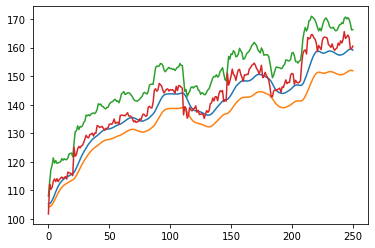

In [26]:
plt.plot(grud_res)
plt.plot(gru_res)
plt.plot(small_sl_rnn_res)
plt.plot(sl_rnn_res)
plt.plot(pd.read_csv)

In [27]:
import supporting_functions as sf

ModuleNotFoundError: No module named 'yahoo_fin'

In [50]:
from tree import node, tree, signal_function
with open(r'Data\Training\test_1\Generations\Gen_24', 'rb') as f:
    gen_mod = pickle.load(f)
best_model = gen_mod[0][np.argmin(gen_mod[1])]
thmo_data = pd.read_csv(r'Data\Stocks\All\THMO.csv')
best_model.predict(thmo_data)
best_model.prediction.iloc[-1]

False

# SCRAPING INDUSTRY LISTS

In [52]:
from lxml import html
import requests
import json
import argparse
from collections import OrderedDict

In [149]:
all_tickers = []
for i in range(100, 2100+100, 100):
    url = 'https://finance.yahoo.com/screener/unsaved/a7936c09-8266-4f9c-8212-d2e1a0e0acfc?offset=0&count={}'.format(i)
    response = requests.get(url, verify=True)
    dissallowed = ['^GSPC', '^DJI', '^IXIC']
    tickers = [text.split(sep=r'"')[0] for text in response.text.split(sep='?p=') if text.split(sep=r'"')[0]
              not in dissallowed and len(text.split(sep=r'"')[0]) <= 6]
    if 'THMO' in tickers:
        print('yes!')
    for ticker in tickers:
        if ticker not in all_tickers:
            all_tickers.append(ticker)

In [142]:
with open(r'Data\Stocks\healthcare_list.pkl', 'wb') as f:
    pickle.dump(all_tickers, f)

In [143]:
# healthcare
# technology
# basic materials
# financial services
# consumer defensive
# utilities
# energy
# consumer cyclical
# real estate
# communication services
# industrials

In [148]:
path = 'Data\\Stocks\\All\\'
tickers = [f.split(sep='.')[0] for f in listdir(path) if isfile(join(path, f))]
with open(r'Data\Stocks\healthcare_list.pkl', 'rb') as f:
    scraped = pickle.load(f)
actual_data = []
for ticker in scraped:
    if ticker in tickers:
        actual_data.append(ticker)
'THMO' in scraped

False

# DATA EXPANSION

In [167]:
import requests
import urllib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
# NewsAPI keys and functions from Ap.ML
keys = ['4310149921f44ec798d954e9fd953cfd',
       '997e1d1d020b431ea8c60be928ab60b4',
       '7508da6e080349959f07d22e27241a13',
       'f3c0ea885d994a97819ec7f422449b91',
       '5e4ec8c18468445a8d5dcaf53fbad42d',
       'f8f52c34988e470d9992e8efe2fee6be']

def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

def generate_search_terms(words):
    term = ''
    for i in range(len(words)-1):
        term += words[i] + '+'
    term += words[-1]
    return term

def newsAPIScrape(query, key):
    url = 'https://newsapi.org/v2/everything?'
    parameters = {
        'q': query, # query phrase
        'pageSize': 100,  # maximum is 100
        'apiKey': key, # your own API key
        'language': 'en'
    }
    response = requests.get(url, params = parameters).json()
    article_data = []
    for entry in response['articles']:
        article_data.append([entry['publishedAt'], vader.polarity_scores(entry['title'])])
        # need to make sure only getting data from one day with no repeated titles
    return article_data

In [169]:
vader = SentimentIntensityAnalyzer()
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Update the lexicon
vader.lexicon.update(new_words)

In [208]:
text = 'Added another 500 shares in $4.50s and up to 8,500 total holdings now. It was great to be able to get back in and buy more again at these reduced prices! Got a bag full! Hehe! Anyone else taking advantage of this opportunity?  :-)'
vader.polarity_scores(text)['compound']

0.9228

In [176]:
today = (datetime.date.today() - datetime.timedelta(days=0)).strftime('%Y-%m-%d')
today

'2020-08-14'

In [203]:
def get_newsapi_vader_sentiment(query, date_str, key, vader_instance):
    url = 'https://newsapi.org/v2/everything?'
    parameters = {
        'q': query, # query phrase
        'pageSize': 100,  # maximum is 100
        'apiKey': key, # your own API key
        'language': 'en', # desired language
        'from': date_str
    }
    response = requests.get(url, params = parameters).json()
    sentiment, collected_articles = [], []
    for article in response['articles']:
        title = article['title']
        date = article['publishedAt'].split(sep='T')[0]
        if date == date_str and title not in collected_articles:
            collected_articles.append(title)
            sentiment.append(vader_instance.polarity_scores(title)['compound'])
    if len(sentiment) == 0:
        return None
    else:
        return np.mean(sentiment)

In [205]:
get_newsapi_vader_sentiment('$AAPL}', today, keys[0], vader)

0.13548333333333334

In [202]:
pd.read_csv('.\\bop\\AAPL.csv')

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-03-14,4.329241,4.437500,4.071429,4.080357,3.532355,107144800.0
1,2000-03-15,4.129464,4.294643,4.075893,4.151786,3.594190,110902400.0
2,2000-03-16,4.189732,4.357143,4.089286,4.341518,3.758441,94525200.0
3,2000-03-17,4.290179,4.464286,4.272321,4.464286,3.864721,76260800.0
4,2000-03-20,4.410714,4.508929,4.370536,4.392857,3.802885,51122400.0
...,...,...,...,...,...,...,...
5135,2020-08-07 00:00:00,452.820007,453.940002,441.179993,444.450012,444.450012,49511403.0
5136,2020-08-10 00:00:00,450.399994,455.089996,440.000000,450.910004,450.910004,53100856.0
5137,2020-08-10 00:00:00,450.399994,455.100006,440.000000,450.910004,450.910004,53032600.0
5138,2020-08-11 00:00:00,447.880005,449.929993,436.429993,437.500000,437.500000,46975600.0
